__File: toy_potential_phase_shifts.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jun 17, 2020__

This notebook looks at the effective range functions of various potentials evaluating the phase shifts at the eigen-energies.

In [1]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from numpy.polynomial.legendre import leggauss
# Scripts made by A.T.
import operators as op
from Potentials.vsrg_macos import load_save_potentials as lsp

In [2]:
# Calculate phase shifts with the following function
def phase_shifts(e_array, V_func, k_array, k_weights):
    '''
    Calculates NN phase shifts [deg] given array of energy values [MeV] (assumed to be in the lab frame). Input
    V_matrix in units fm^-2.
    '''
        
    N = len(k_array)
    hbar_c = 197.32697 # MeV*fm
    # Mass of nucleon in fm^-1
    M = (938.272+939.565) / (2*hbar_c)
        
    e_array /= hbar_c # Convert energy to fm^-1
    l = len(e_array)
    ps_array = np.zeros(l)
    
    V_matrix = np.zeros( (N+1, N+1) )
    
    # Loop over energies
    for i, ie in enumerate(e_array):
        
        k0 = np.sqrt(ie*M/2.0) # fm^-1

        # Build u_j vector
        k_vec = k_array
        w_vec = k_weights
        u_vec = 2.0/np.pi * ( w_vec*k_vec**2 ) / ( (k0**2-k_vec**2)/M )
        # N+1 element of u_vec
        u_last = -2.0/np.pi*np.sum( k0**2*w_vec/ ( (k0**2-k_vec**2)/M ) )
        u_vec = np.append(u_vec, u_last) # Length is N+1, units fm^-2
        
        # Append V(ki,k0),V(k0,kj),V(k0,k0) to V_ij
        # V_matrix is hermitian
        V_k0_vec = np.array( [ V_func(k_array[i], k0) for i in range(N) ] )
        V_matrix[N, :N] = V_k0_vec
        V_matrix[:N, N] = V_k0_vec
        V_matrix[N, N] = V_func(k0, k0)
        # V_matrix is N+1 x N+1, units fm^2
        
        # Build A matrix
        A = np.diag( np.ones(N+1) ) - V_matrix * u_vec # N+1 x N+1, unitless
         
        # Calculate R matrix
        R = np.dot(la.inv(A), V_matrix) # N+1 x N+1, units fm^2
        
        # Note: R[N,N] is the N+1,N+1 element of R
        ps_array[i] = np.arctan( -M * k0 * R[N, N]) 
    
    # Return phase shifts in [deg]
    return ps_array * 180.0/np.pi

__Details of toy NN potential__:

Toy potential for proton-neutron scattering for the $^1$S$_0$ partial wave. Fit to experimental phase shifts and is given in coordinate space by $V(r)=V_a e^{-a x} / x + V_b e^{-b x} / x + V_c e^{-c x} / x$, where $x = \mu r$, $\mu = 0.7$ fm$^{−1}$ (the inverse of the pion mass), $V_a = −10.463$ MeV and $a=1$, $V_b =−1650.6$ MeV and $b=4$ and $V_c = 6484.3$ MeV and $c=7$. In momentum space, $V_{\eta} e^{-\eta x} / x \rightarrow V_{\eta} / (4 \mu k k') log[( (\mu \eta)^2 + (k+k')^2 ) / ( (\mu \eta)^2 + (k-k')^2 ) ]$. We skip to this step in what follows.

In [3]:
def V_func(k, kp):

    # Parameters
    mu = 0.7 # fm^-1
    hbar_c = 197.32697 # MeV*fm
    V_a = -10.463 / hbar_sq_over_M # fm^-2
    a = 1
    V_b = -1650.6 / hbar_sq_over_M # fm^-2
    b = 4
    V_c = 6484.3 / hbar_sq_over_M # fm^-2
    c = 7

    # Get rows and columns of momentum values
    row, col = np.meshgrid(k_array, k_array)

    # Construct momentum-space potential in units
    return ( V_a * np.log( ( (mu*a)**2 + (k+kp)**2 ) / ( (mu*a)**2 + (k-kp)**2 ) ) + \
             V_b * np.log( ( (mu*b)**2 + (k+kp)**2 ) / ( (mu*b)**2 + (k-kp)**2 ) ) + \
             V_c * np.log( ( (mu*c)**2 + (k+kp)**2 ) / ( (mu*c)**2 + (k-kp)**2 ) ) ) / (4 * mu * k * kp)

In [4]:
# Construct Gauss-Legendre quadrature momentum mesh (units are fm^-1)

# Minimum momentum value
k_min = 0.0
# Maximum momentum value
k_max = 10.0
# Number of nodes
ntot = 120
x_array, k_weights = leggauss(ntot)
# Convert from interval [-1, 1] to [k_min, k_max] (meaning x_array -> k_array)
k_array = 0.5 * (x_array + 1) * (k_max - k_min) + k_min

In [5]:
# Calculate relative kinetic energy

# h-bar^2 / M [MeV fm^2]
hbar_sq_over_M = 41.47
# Relative kinetic energy in units MeV
T_matrix = hbar_sq_over_M * np.diag( k_array**2 )

In [6]:
# Construct potential as a matrix in units MeV

# Rows and columns of momenta
row, col = np.meshgrid(k_array, k_array)

# Convert potential to units MeV
factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array # fm^-3/2
factor_row, factor_col = np.meshgrid(factor_array, factor_array)

V_matrix = V_func(row, col) * factor_row * factor_col

In [7]:
# # Obtain Hamiltonian in units MeV and calculate eigenenergies

# # Add to T_rel to get Hamiltonian in units MeV
# H_matrix = T_matrix + V_matrix

# # Get eigenvalues
# eigenvalues, eigenvectors = la.eigh(H_matrix)
# print('--- Eigenenergies [MeV] ---')
# for eig in eigenvalues:
#     print('%.3f' % eig)

In [8]:
# Calculate phase shifts of V(k,k') at eigenenergies
# Function takes E_lab as argument -> multiply eigenenergies by 2 (then it will evaluate at E_lab = 2*E_i which
# gives E_CoM = E_i)

V_fnc = lambda k, kp: V_func(k, kp)

e_array = np.concatenate( (np.arange(0.1, 1.0, 0.1), np.arange(1.0, 100.0, 1.0)) )
delta_array = phase_shifts(e_array, V_fnc, k_array, k_weights)
# delta_array_alt = phase_shifts(e_array, V_matrix_alt, k_array_alt, k_weights_alt)
#delta_array = phase_shifts(2*eigenvalues, V_matrix / hbar_sq_over_M, k_array, k_weights)

# # Manually correct shifts in \pi
# for i, delta in enumerate(delta_array):
#     if eigenvalues[i] < 1000.0 and delta < 0.0:
#         delta_array[i] = delta + 180.0

# You will run into a problem where k0 = np.sqrt( E / hbar_sq_over_M ) > k_max of mesh
# This gives a RuntimeWarning because the log function has a negative value - get rid of the NaN

# e_array = np.zeros(ntot)
# for i in range(ntot):
#     if np.isnan(delta_array[i]):
#         e_array = np.delete(eigenvalues, i)
#         delta_array = np.delete(delta_array, i)
#     else:
#         e_array = eigenvalues[i]

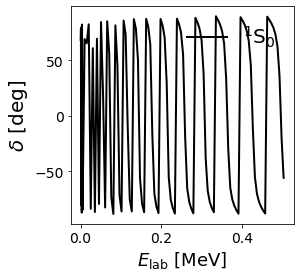

In [9]:
# Plot phase shifts

# Figure size
width = 4
height = 4
figure_size = (width, height)
    
# x-axis limit
#xlim = [0.0, max(eigenvalues)]
        
# Axes labels and fontsize
#x_label = r'$E_n$' + ' [MeV]'
x_label = r'$E_{\rm lab}$' + ' [MeV]'
x_label_size = 18
y_label = r'$\delta$' + ' [deg]'
y_label_size = 20
axes_tick_size = 14
    
# Curve width
curve_width = 2.0

# Curve color, styles, and labels
curve_color = 'xkcd:black'
curve_label = r'$^1$' + 'S' + r'$_0$'

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size) 
        
# Add curve to figure
ax.plot(e_array, delta_array, color=curve_color, label=curve_label, linewidth=curve_width)

# Specify x-axis limit
#ax.set_xlim(xlim)
    
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)
    
# Enlarge axes tick marks
ax.tick_params(labelsize=axes_tick_size)

# Add legend for channel
legend_size = 20
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Save figure
file_name = 'phase_shifts_toy_potential_%d_knodes_kmax%d.pdf' % (ntot, k_max)
f.savefig(file_name, bbox_inches='tight')

In [10]:
# Calculate p*cot(\delta)

# p_array = np.sqrt(e_array / hbar_sq_over_M)
# pcot_array = p_array / np.tan(delta_array)
# print(pcot_array)

In [11]:
# # Plot p*cot(\delta)

# # Figure size
# width = 4
# height = 4
# figure_size = (width, height)
    
# # x-axis limit
# xlim = [0.0, max(eigenvalues)]
        
# # Axes labels and fontsize
# x_label = r'$E_n$' + ' [MeV]'
# x_label_size = 18
# y_label = r'$\delta$' + ' [deg]'
# y_label_size = 20
# axes_tick_size = 14
    
# # Curve width
# curve_width = 2.0

# # Curve color, styles, and labels
# curve_color = 'xkcd:black'
# curve_label = r'$^1$' + 'S' + r'$_0$'

# # Initialize figure
# plt.close('all')
# f, ax = plt.subplots(figsize=figure_size) 
        
# # Add curve to figure
# ax.scatter(e_array, delta_array, color=curve_color, label=curve_label, linewidth=curve_width)

# # Specify x-axis limit
# ax.set_xlim(xlim)
    
# # Set axes labels
# ax.set_xlabel(x_label, fontsize=x_label_size)
# ax.set_ylabel(y_label, fontsize=y_label_size)
    
# # Enlarge axes tick marks
# ax.tick_params(labelsize=axes_tick_size)

# # Add legend for channel
# legend_size = 20
# legend_location = 'lower right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

In [12]:
# Elab = 10 MeV,  delta = 57.47

In [13]:
class phase_shifts(object):
    
    def __init__(self):
        '''Define constants, load momentum and weights, and calculate V_ij'''
        
        # h-bar*c for conv. purposes
        self.hc = 197.32697 # MeV*fm
        # Mass of nucleon in fm^-1
        self.m = (938.272+939.565)/2.0/self.hc
        
        # Load momentum, gp, and Gaussian weights, gw
        gp, gw = lsp.load_momentum(900, '3S1')
        self.gp = gp
        self.gw = gw
        
        # Build V_ij mesh
        N = len(gp)
        self.dim = N
        V_matrix = np.zeros([N+1,N+1])
        
        for i in range(N):
            for j in range(N):
                V_matrix[i,j] = self.V(gp[i],gp[j])
        
        self.V_matrix = V_matrix
        
    def V(self,k,kp):
        '''Arguments are momenta k and k-prime (kp) in units of fm^-1'''
    
        # Units fm^-1
        mu = 0.7 # Inverse of the pion mass
        V_a = -10.463/self.hc
        V_b = -1650.6/self.hc
        V_c = 6484.3/self.hc
        # Unitless
        a = 1.0
        b = 4.0
        c = 7.0
    
        # Returns V(k,kp) in units fm^2
        return 1.0/(4.0*mu*k*kp) * ( \
               V_a*np.log( ( (mu*a)**2+(k+kp)**2 ) / ( (mu*a)**2+(k-kp)**2 ) ) + \
               V_b*np.log( ( (mu*b)**2+(k+kp)**2 ) / ( (mu*b)**2+(k-kp)**2 ) ) + \
               V_c*np.log( ( (mu*c)**2+(k+kp)**2 ) / ( (mu*c)**2+(k-kp)**2 ) ) )  
        
    def delta(self,e):
        '''Returns phase shift delta as a function of lab energy, e [MeV]'''
        
        N = self.dim
        m = self.m # fm^-1
        
        e /= self.hc # Convert energy to fm^-1
        k0 = np.sqrt(e*m/2.0) # fm^-1
        
        # Build u_j vector
        k_vec = self.gp
        w_vec = self.gw
        u_vec = 2.0/np.pi * ( w_vec*k_vec**2 ) / ( (k0**2-k_vec**2)/m )
        # N+1 element of u_vec
        u_last = -2.0/np.pi*np.sum( k0**2*w_vec/ ( (k0**2-k_vec**2)/m ) )
        u_vec = np.append(u_vec,u_last) # Length is N+1, units fm^-2
        
        # Append V(ki,k0),V(k0,kj),V(k0,k0) to V_ij
        V_matrix = self.V_matrix
        # V_matrix is hermitian
        V_k0_vec = np.array([self.V(self.gp[i],k0) for i in range(N)])
        V_matrix[N,:N] = V_k0_vec
        V_matrix[:N,N] = V_k0_vec
        V_matrix[N,N] = self.V(k0,k0)
        # V_matrix is N+1 x N+1, units fm^2
        
        # Build A matrix
        A = np.diag(np.ones(N+1))-V_matrix*u_vec # N+1 x N+1, unitless
        
        # Calculate R matrix
        R = np.dot(la.inv(A),V_matrix) # N+1 x N+1, units fm^2
        
        # Return phase shift, delta, in degrees
        # Note: R[N,N] is the N+1,N+1 element of R
        return np.arctan(-m*k0*R[N,N])*180.0/np.pi

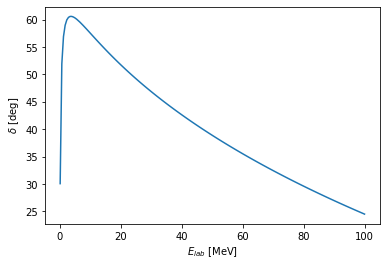

In [14]:
e_array = np.append(np.linspace(0.1,5.0,10),np.linspace(5.5,100.0,90))
ps = phase_shifts()
p_array = np.array([ps.delta(ie) for ie in e_array])
    
plt.plot(e_array,p_array)
plt.xlabel(r'$E_{lab}$ [MeV]')
plt.ylabel(r'$\delta$ [deg]')
plt.show()